In [1]:
import datetime
from IPython.display import Image
import tensorflow as tf
import numpy as np
import os
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/crypto736/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/home/crypto736/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot 함수를 정의합니다.
def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        plt.imshow(sample.reshape(28, 28))
    return fig

In [4]:
# 학습때 필요한 Hyperparameter를 설정해놓습니다.
batch_size = 64
learning_rate = 0.001
epoch = 1000

In [5]:
# 이미지 데이터와 제너레이터의 z를 받아올 placeholder를 생성해 놓습니다.
# 그냥 불러오면 784개의 한줄짜리 데이터이기 때문에 28x28x1로 모양을 바꿔줍니다.
# 또한 variable initializer도 설정해줍니다.
x = tf.placeholder(tf.float32, shape=[None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])
z_in = tf.placeholder(tf.float32, shape=[batch_size, 100])
initializer = tf.truncated_normal_initializer(stddev=0.02)

In [6]:
# discriminator가 더 잘 학습되도록 그냥 relu 대신 leaky relu를 구현했습니다.
# tf.maximum(x, a*x)로 하는 방법도 있지만 메모리를 두배로 쓰기 때문에 아래와 같이 구현했습니다.
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
# Generator를 만들어줍니다. 
def generator(z):
    with tf.variable_scope("generator"):
        fc1 = tf.contrib.layers.fully_connected(inputs=z, num_outputs=7*7*128, 
                                                activation_fn=tf.nn.relu, 
                                                normalizer_fn=tf.contrib.layers.batch_norm,
                                                weights_initializer=initializer,
                                                scope="g_fc1")
        fc1 = tf.reshape(fc1, shape=[batch_size, 7, 7, 128])
        conv1 = tf.contrib.layers.conv2d(fc1, num_outputs=4*64, kernel_size=5, 
                                         stride=1, padding="SAME",activation_fn=tf.nn.relu,
                                         normalizer_fn=tf.contrib.layers.batch_norm, 
                                         weights_initializer=initializer,scope="g_conv1")
        conv1 = tf.reshape(conv1, shape=[batch_size,14,14,64])
        conv2 = tf.contrib.layers.conv2d(conv1, num_outputs=4*32, kernel_size=5,
                                         stride=1, padding="SAME", activation_fn=tf.nn.relu,
                                         normalizer_fn=tf.contrib.layers.batch_norm, 
                                         weights_initializer=initializer,
                                         scope="g_conv2")
        conv2 = tf.reshape(conv2, shape=[batch_size,28,28,32])
        conv3 = tf.contrib.layers.conv2d(conv2, num_outputs=1, kernel_size=5, 
                                         stride=1, padding="SAME", 
                                         activation_fn=tf.nn.tanh,
                                         scope="g_conv3")
        return conv3

In [8]:
# Discriminator도 만들어줍니다.
def discriminator(tensor,reuse=False):
    with tf.variable_scope("discriminator"):
        conv1 = tf.contrib.layers.conv2d(inputs=tensor, num_outputs=32,
                                         kernel_size=5, stride=2, padding="SAME", 
                                        reuse=reuse, activation_fn=lrelu,
                                         weights_initializer=initializer,
                                         scope="d_conv1")
        conv2 = tf.contrib.layers.conv2d(inputs=conv1, num_outputs=64, 
                                         kernel_size=5, stride=2, padding="SAME", 
                                         reuse=reuse, activation_fn=lrelu,
                                         normalizer_fn=tf.contrib.layers.batch_norm,
                                         weights_initializer=initializer,
                                         scope="d_conv2")
        fc1 = tf.reshape(conv2, shape=[batch_size, 7*7*64])
        fc1 = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=512,reuse=reuse,
                                                activation_fn=lrelu, 
                                                normalizer_fn=tf.contrib.layers.batch_norm, 
                                                weights_initializer=initializer,
                                                scope="d_fc1")
        fc2 = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=1, reuse=reuse,
                                                activation_fn=tf.nn.sigmoid,
                                                weights_initializer=initializer,
                                                scope="d_fc2")
        return fc2


In [9]:
# 학습을 시키기 위해서는 D(G(z))와 D(x)가 필요하기 때문에 아래처럼 그래프를 만들어줍니다.
g_out = generator(z_in)
d_out_fake = discriminator(g_out)
d_out_real = discriminator(x_image,reuse=True)

In [10]:
# loss는 논문에 나온대로 구현합니다.
disc_loss = tf.reduce_sum(tf.square(d_out_real-1) + tf.square(d_out_fake))/2
gen_loss = tf.reduce_sum(tf.square(d_out_fake-1))/2

In [11]:
# 여기부터가 제가 좀 헷갈렸던 부분인데 gen_loss는 generator만 업데이트하고
# disc_loss는 discriminator만 업데이트하도록 하기 위해서 
# 각 name_scope에서 variable을 불러옵니다.
gen_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator") 
dis_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator")

In [12]:
# 그 다음엔 loss에 대한 해당 variable의 gradient를 구해 이를 업데이트 합니다.
d_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
g_optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
d_grads = d_optimizer.compute_gradients(disc_loss,dis_variables) 
g_grads = g_optimizer.compute_gradients(gen_loss,gen_variables) 
update_D = d_optimizer.apply_gradients(d_grads)
update_G = g_optimizer.apply_gradients(g_grads)

In [13]:
# 생성된 이미지들을 저장할 generated_outputs 폴더를 생성합니다.
num_img = 0
if not os.path.exists('generated_output/'):
    os.makedirs('generated_output/')

In [14]:
start_time = datetime.datetime.now()

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        batch = mnist.train.next_batch(batch_size)
        z_input = np.random.uniform(0,1.0,size=[batch_size,100]).astype(np.float32)
        _, d_loss = sess.run([update_D,disc_loss],feed_dict={x: batch[0], z_in: z_input})
        for j in range(4):
            _, g_loss = sess.run([update_G,gen_loss],feed_dict={z_in: z_input})
            #print("i: {} / d_loss: {} / g_loss: {}".format(i,np.sum(d_loss)/batch_size, np.sum(g_loss)/batch_size))
        if i % 5 == 0:
            gen_o = sess.run(g_out,feed_dict={z_in: z_input})
            fig = plot(gen_o)
            plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
            num_img += 1
            plt.close(fig)

end_time= datetime.datetime.now()
learning_time = end_time - start_time
print('훈련시간: %d 마이크로초' % learning_time.microseconds)
print('훈련시간: %d 초' % learning_time.seconds)

훈련시간: 117803 마이크로초
훈련시간: 4919 초


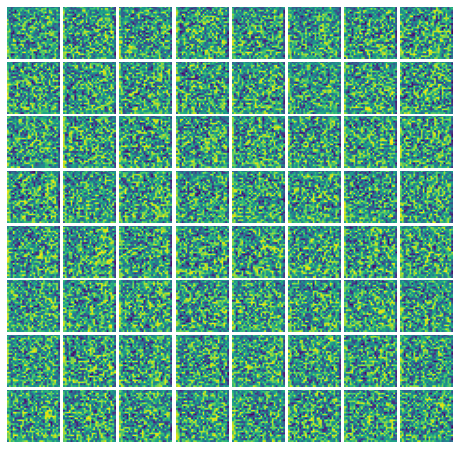

In [16]:
Image('generated_output/000.png')

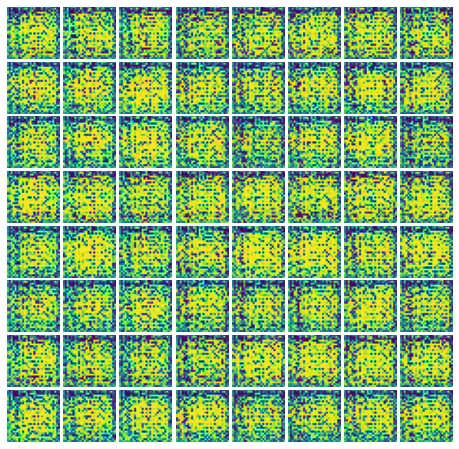

In [17]:
Image('generated_output/009.png')

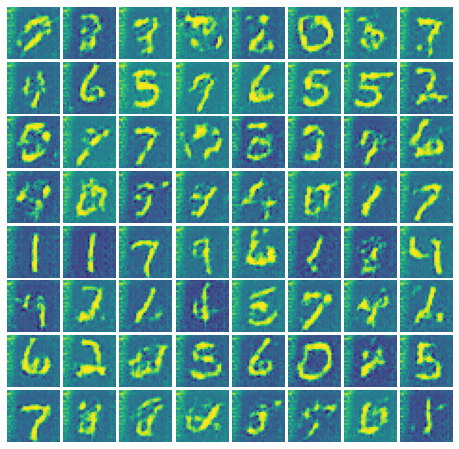

In [18]:
Image('generated_output/099.png')

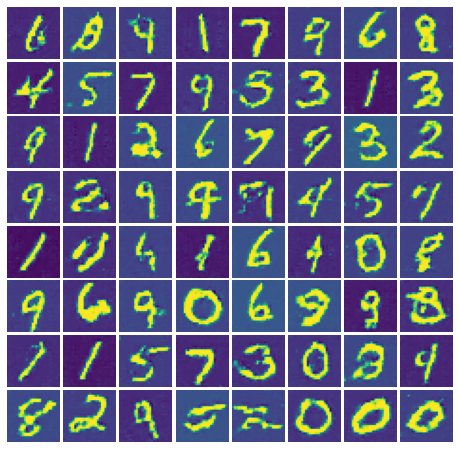

In [19]:
Image('generated_output/199.png')

In [ ]:
'''
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epoch):
        batch = mnist.train.next_batch(batch_size)
        z_input = np.random.uniform(0,1.0,size=[batch_size,100]).astype(np.float32)
        _, d_loss = sess.run([update_D,disc_loss],feed_dict={x: batch[0], z_in: z_input})
        for j in range(4):
            _, g_loss = sess.run([update_G,gen_loss],feed_dict={z_in: z_input})
            print("i: {} / d_loss: {} / g_loss: {}".format(i,np.sum(d_loss)/batch_size, np.sum(g_loss)/batch_size))
        if i % 500 == 0:
            gen_o = sess.run(g_out,feed_dict={z_in: z_input})
            fig = plot(gen_o)
            plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches='tight')
            num_img += 1
            plt.close(fig)

end_time= datetime.datetime.now()
learning_time = end_time - start_time
print('훈련시간: %d 마이크로초' % learning_time.microseconds)
print('훈련시간: %d 초' % learning_time.seconds)
'''